In [1]:
from pathlib import Path
import asyncio
from IPython.display import display
from llama_server import LlamaServer

Download the quantized LLaVa model on [huggingface](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main) and save them to the folder "llms"


#### Configure server options

In [2]:
config = {
    "alias": "LLaVA 1.5",
    "model": "./llms/llava-v1.5-q5_k.gguf",
    "multimodal_projector": "./llms/llava-mmproj-f16.gguf",
    "image_width": 300,
    "server_exe": "../llama_server",
    "system_prompt": "./llava_prompt.json",
    "prefix": "User:",
    "suffix": "\nAssistant:",
}
slots = 10 # slots for parallel inference
context_size = 4096

#### Start the server

In [3]:
llm = LlamaServer(config, context_size=context_size, slots=slots)
proc = await llm.start_server()

2023-11-05 19:48:00.569 GMT: Multimodal inference currently only works with one slot. Slot number is changed to 1.
2023-11-05 19:48:03.576 GMT: Server online.


#### Inference with image as input

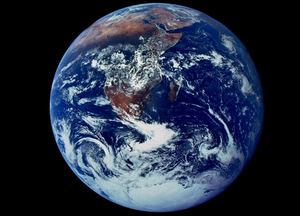

The image shows a close up of the Earth from space. It is nighttime, and the Earth appears to be blue with some clouds. The picture captures the beauty and vastness of our planet as it spins in its orbit around the sun.


In [4]:
prompt = "Please describe concisely the content of the shown figure."
result, image = await llm.query(prompt, "./figures/earth.jpg", n_predict=200)
display(image)
print(result["content"].strip())

#### Change the system prompt at runtime

In [5]:
system_prompt = {
    "prompt": (
        "You should only answer '😅' to the user's questions.\n"
        "User: how is the weather?\n"
        "Assistant: 😅\n"
    ),
    "anti_prompt": "User",
    "assistant_name": "Assistant"
}
await llm.update_system_prompt(system_prompt)

True

In [6]:
prompt = "Please tell me the value of $\gamma$."
result, _ = await llm.query(prompt, n_predict=100)
answer = result["content"].strip()
print(f"Q: {prompt}\nA: {answer}")


Q: Please tell me the value of $\gamma$.
A: 😅


#### There is some issue with long system prompt when using LLaVa

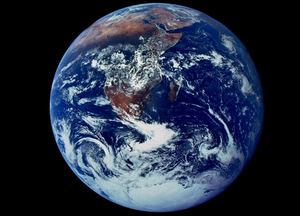

The The The The


In [7]:
prompt = "Please describe concisely the content of the shown figure."
result, image = await llm.query(prompt, "./figures/earth.jpg", n_predict=100)
display(image)
print(result["content"].strip())

#### Reset to a normal system prompt

In [8]:
system_prompt = {
    "prompt": "A chat between a curious user and an artificial intelligence assistant.",
    "anti_prompt": "User",
    "assistant_name": "Assistant"
}
await llm.update_system_prompt(system_prompt)

True

#### Batch inference
Not in parallel since currently llama.cpp only generate correct results with a single slot with LLaVa. 

In [9]:
prompts = [
    "How to build a website?",
    "Teach me how to calculate $\pi$?"
]
results, _ = await llm.batch_query(prompts, stop=["User:","user:"])
for prompt, result in zip(prompts, results):
    answer = result["content"].strip()
    print(f"Q: {prompt}\nA: {answer}")
    print("-"*20)

Q: How to build a website?
A: Building a website involves several steps, including planning, designing, developing, and launching. Here is an overview of the process:

1. Planning: The first step in building a website is to plan what you want your website to achieve. This includes identifying your target audience, determining the purpose of your website, and setting goals for your site.
2. Designing: Once you have a clear idea of what you want your website to accomplish, you can start designing it. This involves choosing a layout, selecting colors and fonts, and creating graphics or images that will be used on your site.
3. Developing: The next step is to develop the website by writing code and creating the necessary functionality. This includes building the structure of the site, adding content, and integrating any features or tools you want to include.
4. Launching: Once your website is complete, you can launch it by making it live on the internet. This involves choosing a domain nam

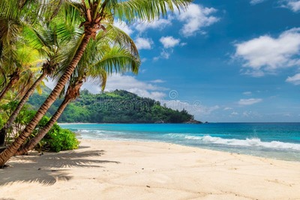

Q: Please describe concisely the content in the above figure.
A: The beach is sandy and has palm trees. There are a few people on the beach, enjoying their time in the sun. In the distance, there is an island visible with mountains behind it.
--------------------


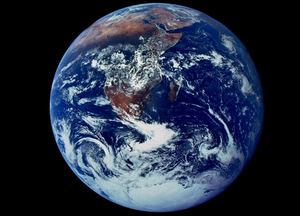

Q: Please describe concisely the content in the above figure.
A: The image shows a close-up of the Earth from space. The planet is surrounded by a black background, emphasizing its beauty and size. The Earth appears to be blue in color with a few clouds scattered around it. The picture captures the essence of our home planet as seen from outer space.
--------------------


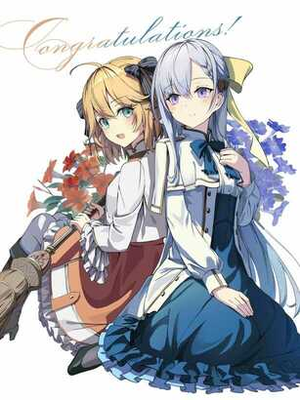

Q: Please describe concisely the content in the above figure.
A: The two girls are sitting next to each other. One girl is wearing a white shirt and the other is wearing a blue dress. Both of them have long hair, and they seem to be posing for a picture.
--------------------


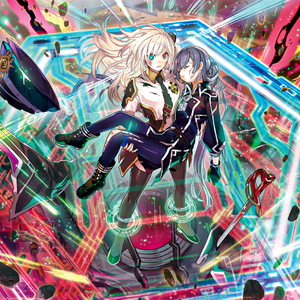

Q: Please describe concisely the content in the above figure.
A: The woman is holding the other woman on her back.
--------------------


In [10]:
images = [f.as_posix() for f in Path("figures/").glob("*.jpg")]
prompts = ["Please describe concisely the content in the above figure."] * len(images)
results, images = await llm.batch_query(prompts,images)
for image, prompt, result in zip(images, prompts, results):
    answer = result["content"].strip()
    display(image)
    print(f"Q: {prompt}\nA: {answer}")
    print("-"*20)

#### Stop the server

In [11]:
llm.stop_server()

-15